In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


os.chdir('/content/drive/MyDrive/DS')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

## Importing data set

I am taking the data set from year 2005 to 2017. Since, data is too big, it is available in to 3 different files. So, first we will import the files in to 3 distinct dataframes and then we concatenate them in to single file.

In [ ]:
df_1 = pd.read_csv("Chicago_Crimes_2005_to_2007.csv", error_bad_lines = False)
df_2 = pd.read_csv("Chicago_Crimes_2008_to_2011.csv", error_bad_lines = False)
df_3 = pd.read_csv("Chicago_Crimes_2012_to_2017.csv", error_bad_lines = False)

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [ ]:
# concatenating the dataframes in to one 
df = pd.concat([df_1, df_2, df_3])

## Data preprocessing

Let's look at first five row to get a broad understanding of data set using dataframe head function.

In [ ]:
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
3,4,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
4,5,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"


Now, let's see how many rows and columns we have in a data set.

In [ ]:
df.shape

(6017767, 23)

As we can see in the above output, the dataframe have more than 6 million rows and 23 columns which is quite huge.

Since, the data is huge we are pretty sure that there will be some NULL values in a columns. To check the NULL values, I am using the seaborn heatmap function to visualize the NULL values.

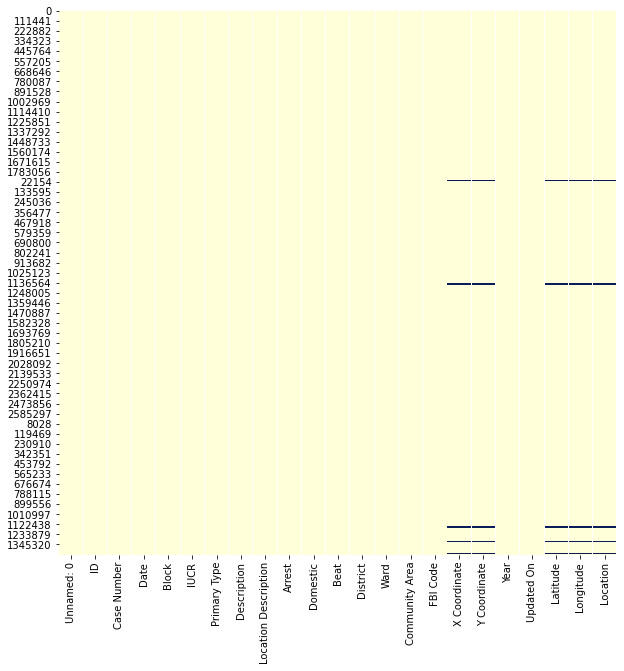

In [ ]:
plt.figure(figsize = (10, 10)) 
sns.heatmap(df.isnull(), cbar = False, cmap = 'YlGnBu')

The blue lines in the above figure are showing the NULL values. The NULL values are present in columns X Coordinates, Y Coordinates, Latitude, Longitude and Location.

Now, our further case study will be on only 5 columns namely Date, Block, Primary Type, Description, Location Description, Arrest and Domestic.

In [ ]:
df_new = df[['Date', 'Block', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic']]
df_new.head()

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
3,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
4,02/17/2006 09:03:14 PM,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False


We have to convert Date column in to appropriate date time format for further time series analysis.

In [ ]:
df_new.Date = pd.to_datetime(df_new.Date, format = '%m/%d/%Y %I:%M:%S %p')
df_new.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
3,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
4,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False


## Exploratory analysis and visualization

Let's see the top 15 criminal activity happens in Chicago from 2015 to 2017.

In [ ]:
df_new['Primary Type'].value_counts().iloc[:15]

THEFT                         1245111
BATTERY                       1079178
CRIMINAL DAMAGE                702702
NARCOTICS                      674831
BURGLARY                       369056
OTHER OFFENSE                  368169
ASSAULT                        360244
MOTOR VEHICLE THEFT            271624
ROBBERY                        229467
DECEPTIVE PRACTICE             225180
CRIMINAL TRESPASS              171596
PROSTITUTION                    60735
WEAPONS VIOLATION               60335
PUBLIC PEACE VIOLATION          48403
OFFENSE INVOLVING CHILDREN      40260
Name: Primary Type, dtype: int64

Theft is most most common criminal activity with more 1.2 million incidence happened between 2005 to 2017.

Let's visualize the above information in a chart for an interactive view using seaborn countplot function.

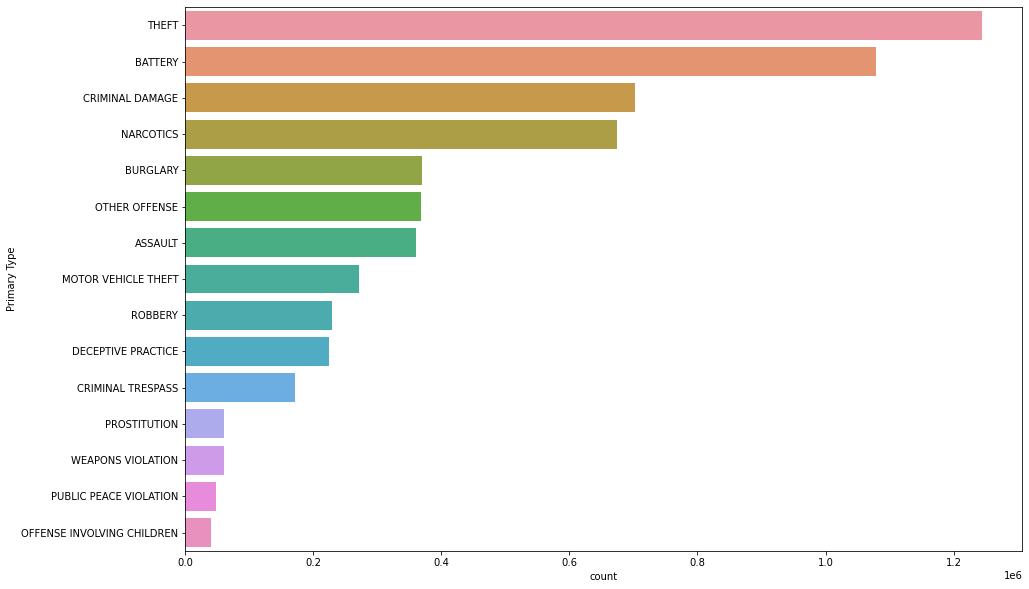

In [ ]:
plt.figure(figsize = (15, 10))
sns.countplot(y = 'Primary Type', data = df_new, order = df_new['Primary Type'].value_counts().iloc[:15].index)

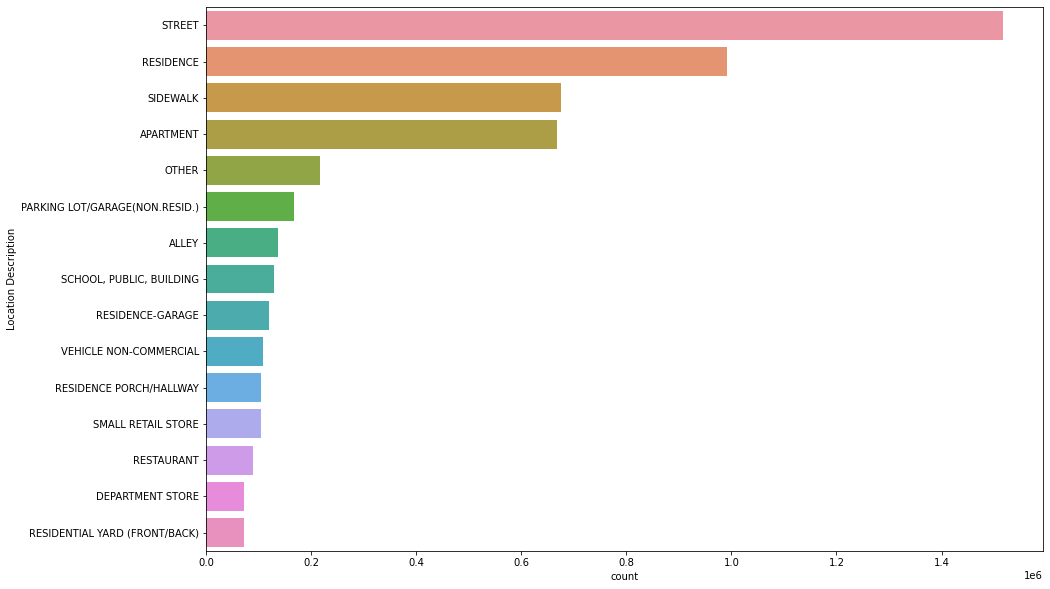

In [ ]:
plt.figure(figsize = (15, 10))
sns.countplot(y = 'Location Description', data = df_new, order = df_new['Location Description'].value_counts().iloc[:15].index)

As we can see in above chart, majority of the crimes happened in Street followed by Residence.

In [ ]:
df_new.index = pd.DatetimeIndex(df_new.Date)
df_new.head()

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
Date,,,,,,,
2006-04-02 13:00:00,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
2006-02-26 13:40:48,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2006-01-08 23:16:00,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
2006-04-05 18:45:00,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
2006-02-17 21:03:14,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False


Let's count the total number of crimes happened per year

In [ ]:
df_new.resample('Y').size()

Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

Text(0, 0.5, 'Number of crimes')

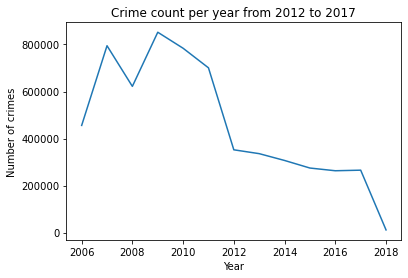

In [ ]:
plt.plot(df_new.resample('Y').size())
plt.title('Crime count per year from 2012 to 2017')
plt.xlabel('Year')
plt.ylabel('Number of crimes')

As we can see in above plot, the crime rate showing the decreasing trend.

You can visualize the crime rate trend per month by just replacing the 'Y' in resample function with 'm' as seen in code below.

Text(0, 0.5, 'Number of crimes')

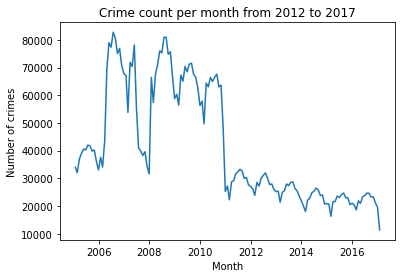

In [ ]:
plt.plot(df_new.resample('m').size())
plt.title('Crime count per month from 2012 to 2017')
plt.xlabel('Month')
plt.ylabel('Number of crimes')

## Making predictions

In [ ]:
# Reseting the index number of rows
chicago_prophet = df_new.resample('m').size().reset_index()
chicago_prophet

,Date,0
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


In [ ]:
# changing the column names for clarity
chicago_prophet.columns = ['Date', 'Crime count']
chicago_prophet

,Date,Crime count
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


Now we have to change the column names in to 'ds' and 'y' because facebook prophet work only with columns whose names are 'ds' and 'y'. If you try to implement prophet without renaming the columns in to 'ds' and 'y', you will get an error.

In [ ]:
chicago_prophet_df_final = chicago_prophet.rename(columns = {'Date': 'ds', 'Crime count': 'y'})
chicago_prophet_df_final

,ds,y
0,2005-01-31,33983
1,2005-02-28,32042
2,2005-03-31,36970
3,2005-04-30,38963
4,2005-05-31,40572
...,...,...
140,2016-09-30,23235
141,2016-10-31,23314
142,2016-11-30,21140
143,2016-12-31,19580


Next, i am fitting the data using prophet.

In [ ]:
m = Prophet()
m.fit(chicago_prophet_df_final)

Now, we forcast the crime rate in next 2 years. This can be done by assigning 720 (365 days * 2) to periods as shown in code below.

In [ ]:
future = m.make_future_dataframe(periods = 720)
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-31,60454.736755,38732.779288,72932.888358,60454.736755,60454.736755,-4762.400048,-4762.400048,-4762.400048,-4762.400048,-4762.400048,-4762.400048,0.0,0.0,0.0,55692.336707
1,2005-02-28,60322.333828,34619.613693,67537.437760,60322.333828,60322.333828,-9500.508891,-9500.508891,-9500.508891,-9500.508891,-9500.508891,-9500.508891,0.0,0.0,0.0,50821.824937
2,2005-03-31,60175.744873,43445.998818,75521.514783,60175.744873,60175.744873,-1224.148242,-1224.148242,-1224.148242,-1224.148242,-1224.148242,-1224.148242,0.0,0.0,0.0,58951.596630
3,2005-04-30,60033.884593,43459.357632,78371.171543,60033.884593,60033.884593,1182.830385,1182.830385,1182.830385,1182.830385,1182.830385,1182.830385,0.0,0.0,0.0,61216.714978
4,2005-05-31,59887.295638,47934.047386,82450.447862,59887.295638,59887.295638,5498.250108,5498.250108,5498.250108,5498.250108,5498.250108,5498.250108,0.0,0.0,0.0,65385.545746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,2019-01-17,5465.369009,-16791.714157,17207.883733,5054.408129,5952.525569,-5243.415089,-5243.415089,-5243.415089,-5243.415089,-5243.415089,-5243.415089,0.0,0.0,0.0,221.953920
861,2019-01-18,5452.302325,-15994.648573,17633.767593,5040.092855,5940.460217,-5243.952208,-5243.952208,-5243.952208,-5243.952208,-5243.952208,-5243.952208,0.0,0.0,0.0,208.350118
862,2019-01-19,5439.235642,-18517.118576,16826.449578,5025.901258,5928.394865,-5241.167658,-5241.167658,-5241.167658,-5241.167658,-5241.167658,-5241.167658,0.0,0.0,0.0,198.067985
863,2019-01-20,5426.168959,-17701.021331,18190.972442,5011.709660,5916.329513,-5233.516084,-5233.516084,-5233.516084,-5233.516084,-5233.516084,-5233.516084,0.0,0.0,0.0,192.652875


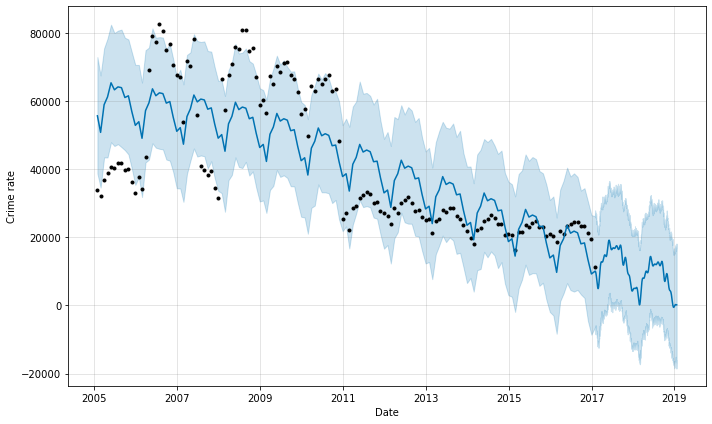

In [ ]:
figure = m.plot(forecast, xlabel = 'Date', ylabel = 'Crime rate')

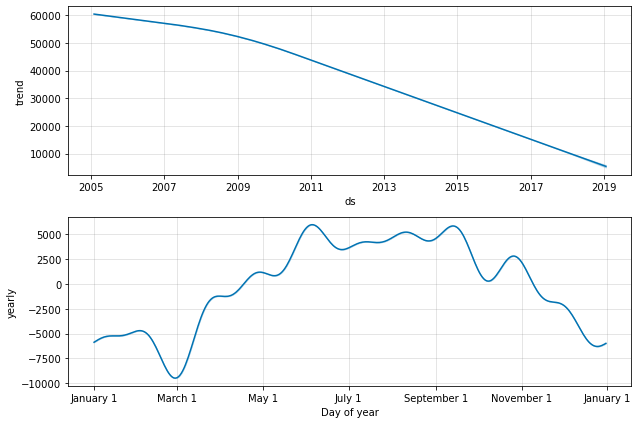

In [ ]:
figure = m.plot_components(forecast)

As we can see in above plots the crime rate is showing the decreasing trend over the years and it will countinue also in next 2 years till 2019.

Also we can notice, in a specific year the crime rate increased in summer between March and November. From mid of May to first week of September is the worst period in term of crime rate. Chicago police should be extra vigilant between this period. 

## Conclusion and results


I found some of the useful results and insights in this notebook. These are

1. Theft is a most common crime in Chicago.
2. Majority of crimes happens on street.
3. There is a decreasing trend in a crime rate over the years which is good news.
4. Majority of the crimes happened in summer between March and November in a specific year. 